### Metric 1a: Mean daily wildfire PM2.5 concentration during wildfire season by census tract

In [1]:
import numpy as np
import numpy.ma as ma
import os
from datetime import datetime, timedelta 
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

In [2]:
current_directory = os.path.dirname(os.getcwd())

### Load Data Files

In [3]:
# Daily Averaged WFS PM2.5 data by Census Tract
relative_path = "Output/Daily_Average_WFS_PM25_by_Census_Tract.csv"
grouped_data_path = os.path.join(current_directory, relative_path)
PM25_by_Tracts_WFS = pd.read_csv(grouped_data_path)

# Census Tracts Shapefile
relative_sf_path = "Raw_Data/Shapefiles/Tracts2020.shp"
grouped_data_CT_path = os.path.join(current_directory, relative_sf_path)
Tracts2020 = gpd.read_file(grouped_data_CT_path)
Tracts2020 = Tracts2020.to_crs(epsg=3338) # NAD AK Albers projection (better to project maps of AK only)

### Calculate Annual Daily Wildfire PM2.5 Concentration

In [4]:
# Filter to only include Wildfire Season (May-September)
PM25_by_Tracts_WFS['Date'] = pd.to_datetime(PM25_by_Tracts_WFS['Date'])
PM25_by_Tracts_WFS['Year'] = PM25_by_Tracts_WFS['Date'].dt.year
WFS_M1_Year_Tract = PM25_by_Tracts_WFS[PM25_by_Tracts_WFS['Date'].dt.month.isin([5, 6, 7, 8, 9])]

# Calculate averages by year and tract
averages_by_year_and_tract = WFS_M1_Year_Tract.groupby(['Year', 'NAME'])['PM2.5'].mean().reset_index()
WFS_M1_Year_Tract = averages_by_year_and_tract.pivot(index='NAME', columns='Year', values='PM2.5')

# Calculate the average across the years
average_2003_2020 = WFS_M1_Year_Tract.loc[:, 2003:2020].mean(axis=1)
WFS_M1_Year_Tract['average_across_years'] = average_2003_2020
WFS_M1_Year_Tract = WFS_M1_Year_Tract.sort_values(by='average_across_years', ascending=False)

# Reset the index to keep Tract Names
WFS_M1_Year_Tract = WFS_M1_Year_Tract.reset_index()

# Export
relative_mean_daily_path = "Output/WFS_M1_annual_averages_census_tracts.csv"
mean_daily_path = os.path.join(current_directory, relative_mean_daily_path)
WFS_M1_Year_Tract.to_csv(mean_daily_path, index=False)

# Preview
WFS_M1_Year_Tract.head()

Year,NAME,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,average_across_years
0,Geist/University West,2.810523,39.878366,11.873399,2.113203,1.544510,1.081111,14.086013,5.020523,5.842745,1.648627,3.521961,1.362353,13.102941,1.132353,1.701111,2.841046,16.130131,0.825033,7.028664
1,Chena River Valley,3.247255,54.508954,10.637843,1.751569,1.575556,0.957255,8.923268,4.642222,2.072418,2.073856,7.725425,1.472941,10.466078,1.256471,1.883464,1.906013,8.970327,0.662549,6.929637
2,FAI/Van Horn,2.808824,45.170588,11.506928,2.184314,1.638366,1.114379,12.793464,4.919020,4.209542,2.090261,4.150523,1.436471,11.807255,1.185752,1.716993,2.478497,12.318562,0.814641,6.908021
3,UAF/Farmers Loop,2.808170,46.391634,11.422484,2.201111,1.659869,1.122418,12.494771,4.895621,3.832288,2.192549,4.295621,1.453856,11.508824,1.198235,1.721046,2.394902,11.438627,0.812614,6.880258
4,Airport Way West,2.808039,46.702418,11.401438,2.205621,1.665359,1.123987,12.419542,4.890458,3.736601,2.218039,4.332222,1.457974,11.432941,1.201307,1.721830,2.373660,11.215359,0.812026,6.873268


## Data Visualization

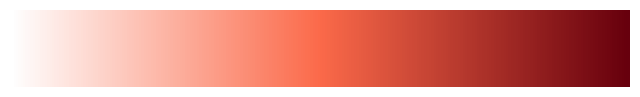

In [5]:
# Define colors: White -> Bright Red -> Deep Dark Red
colors = ["white", "#FB6A4A", "#67000D"]  # Bright red (#FB6A4A) from Reds at ~midpoint
WhiteToRed = mcolors.LinearSegmentedColormap.from_list("WhiteToBrightToDarkRed", colors)

# Test colormap with a gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)

fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(gradient, aspect="auto", cmap=WhiteToRed)
ax.set_axis_off()
plt.show()

# Individual Maps

In [6]:
# Maps Output Folder Path
relative_output_file_path = "Output"
output_folder = os.path.join(current_directory, relative_output_file_path)

In [7]:
# Define the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)

# Exclude 'average_across_years' and 'NAME'
years_to_plot = [year for year in WFS_M1_Year_Tract.columns if year not in ['average_across_years', 'NAME']]

# Merge the census data with the entire WFS_M1_Year_Tract
WFS_M1_Annual_Tract_wGeo = Tracts2020.merge(WFS_M1_Year_Tract, on='NAME', how='inner')
WFS_M1_Annual_Tract_wGeo_Annual = Tracts2020.merge(WFS_M1_Year_Tract, on='NAME', how='inner')

# Round values to one decimal place
WFS_M1_Annual_Tract_wGeo_Annual[years_to_plot] = WFS_M1_Annual_Tract_wGeo_Annual[years_to_plot].astype(float).round(1)
WFS_M1_Annual_Tract_wGeo_Annual = WFS_M1_Annual_Tract_wGeo_Annual

# Set vmin and vmax based on the overall data
vmin = 0
vmax = WFS_M1_Annual_Tract_wGeo_Annual[years_to_plot].max().max()  # Find the overall maximum across all years

# Generate tick positions for colorbar
ticks = np.arange(0, vmax + 10, 10)

# Iterate over each year
for year in years_to_plot:
    # Create a figure and GeoAxes with the Albers Equal Area projection
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': alaska_albers}, figsize=(8, 6))
    
    # Plotting the shapefile with a color based on Avg_PM25 values for the specific year
    WFS_M1_Annual_Tract_wGeo_Annual.plot(ax=ax, column=year, cmap=WhiteToRed, transform=alaska_albers, 
                                  legend=False, vmin=vmin, vmax=vmax)
    
    # Add thin black border to the shapefile data
    WFS_M1_Annual_Tract_wGeo_Annual.boundary.plot(ax=ax, color='black', linewidth=0.20, transform=alaska_albers)
    
    # Set plot title
    ax.set_title(f"{year}", fontsize=14)
    
    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')

    # Add colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToRed),
                        ax=ax, orientation='horizontal', fraction=0.036, pad=0.1, ticks=ticks)
    cbar.set_label(r'$\mathrm{PM}_{2.5}\, (\mu g/m^3)$', fontsize=12)
    
    # Save the individual map to the output folder
    output_file_path = f"{output_folder}/WFS_M1a_{year}.png"
    plt.savefig(output_file_path, dpi=300, bbox_inches='tight')
    
    # Close the figure to save memory
    plt.close(fig)

print("All individual maps have been saved to:", output_folder)

All individual maps have been saved to: /mnt/c/Users/nrathauda/OneDrive - University of Alaska/NIMHD K01 - wildfire and birth outcomes/Alaska_wildfire-smoke-metrics_2025/Output


# Panel Map

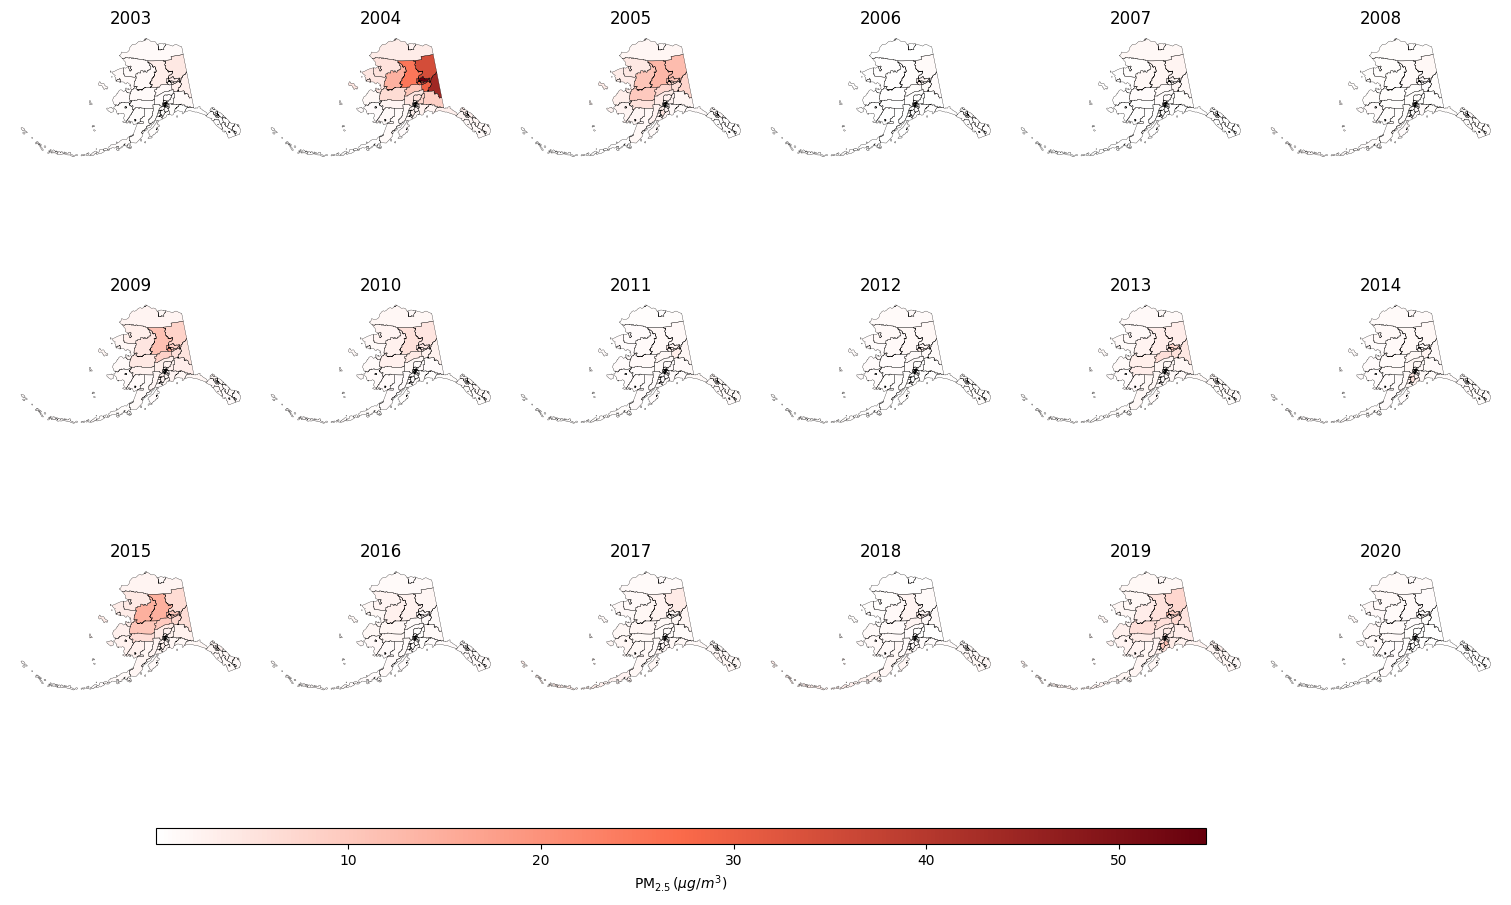

In [8]:
# Number of rows and columns for the panel
num_rows = 3
num_cols = 6

# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': alaska_albers}, figsize=(15, 8), constrained_layout=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Excluding 'average_across_years' and 'NAME'
years_to_plot = [year for year in WFS_M1_Year_Tract.columns if year not in ['average_across_years', 'NAME']]

# Merge the census data with the entire WFS_M1_Year_Tract
WFS_M1_Annual_Tract_wGeo = Tracts2020.merge(WFS_M1_Year_Tract, on='NAME', how='inner')

# Iterate over each year
for i, year in enumerate(years_to_plot):
    # Set vmin and vmax based on the current year's data
    vmin = 0
    vmax = WFS_M1_Annual_Tract_wGeo[years_to_plot].max().max()  # Find the overall maximum across all years

    # Plotting the shapefile with a color based on Avg_PM25 values for the specific year
    WFS_M1_Annual_Tract_wGeo.plot(ax=axes[i], column=year, cmap=WhiteToRed, transform=alaska_albers, legend=False, vmin=vmin, vmax=vmax)

    # Add thin black border to the shapefile data
    WFS_M1_Annual_Tract_wGeo.boundary.plot(ax=axes[i], color='black', linewidth=0.20, transform=alaska_albers)

    # Set plot title
    axes[i].set_title(f"{year}")

    # Remove axes ticks and labels
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])

    # Remove frame around each subplot
    axes[i].axis('off')
    
# Generate tick positions for colorbar
ticks = np.linspace(vmin, vmax, num=5)  # Ensure this is a 1D array

# Generate a single colorbar for all plots
cbar_ax = fig.add_axes([0.1, -0.1, 0.7, 0.02])  # Adjust the width of the colorbar here
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToRed),
                    cax=cbar_ax, orientation='horizontal', ticks=[10,20,30,40,50])
cbar.set_label(r'$\mathrm{PM}_{2.5}\, (\mu g/m^3)$')

# Draw the figure to ensure everything is properly rendered
plt.draw()

# Export the image, ensuring tight layout so the colorbar isn't cut off
output_file_path = f"{output_folder}/WFS_M1a_Panel.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Show the figure in the notebook
plt.show()

## Cumulative Map
Wildfire Season Only Data

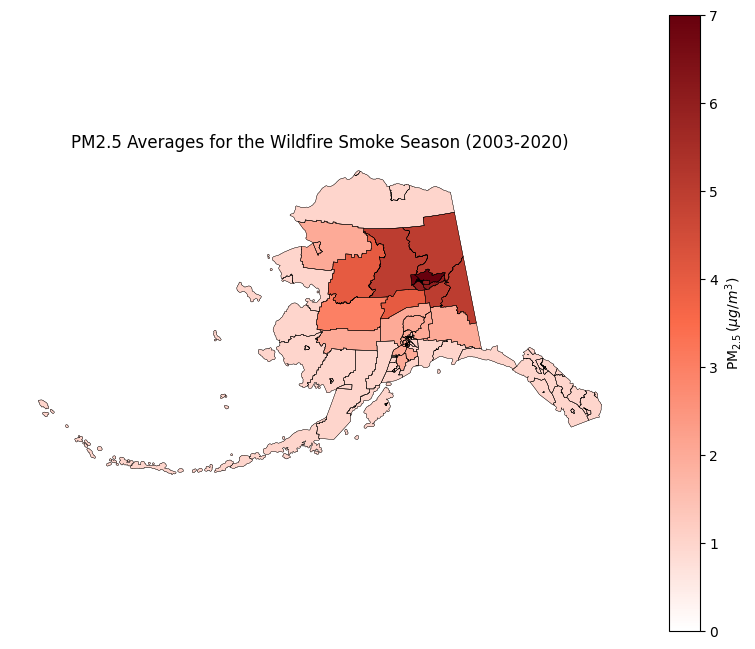

In [9]:
# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, ax = plt.subplots(subplot_kw={'projection': alaska_albers}, figsize=(10, 8))

# Merge the census data with the WFS_M1_Year_Tract DataFrame
WFS_M1_Cummul_Tract_wGeo = Tracts2020.merge(WFS_M1_Year_Tract, on='NAME', how='inner')

# Round the 'average_across_years' values to whole numbers
WFS_M1_Cummul_Tract_wGeo['average_across_years'] = WFS_M1_Cummul_Tract_wGeo['average_across_years'].round()

# Set vmin and vmax 
vmin = 0
vmax = WFS_M1_Cummul_Tract_wGeo['average_across_years'].max()

# Plotting the shapefile
WFS_M1_Cummul_Tract_wGeo.plot(ax=ax, column='average_across_years', cmap=WhiteToRed, transform=alaska_albers, legend=False, vmin=vmin, vmax=vmax)

# Add thin black border to the shapefile data
WFS_M1_Cummul_Tract_wGeo.boundary.plot(ax=ax, color='black', linewidth=0.20, transform=alaska_albers)

# Variable handling
WFS_M1_Cummul_Tract_wGeo.columns = WFS_M1_Cummul_Tract_wGeo.columns.astype(str)

# Round
WFS_M1_Cummul_Tract_wGeo['average_across_years'] = WFS_M1_Cummul_Tract_wGeo['average_across_years'].round(1)

# Set vmin and vmax based on the 'average_across_years' data
vmin = 0
vmax = WFS_M1_Cummul_Tract_wGeo['average_across_years'].max()

# Plot the shapefile data with a custom legend title
WFS_M1_Cummul_Tract_wGeo.plot(
    ax=ax,
    column='average_across_years',
    cmap=WhiteToRed,
    transform=alaska_albers,
    legend=True,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={'label': r'$\mathrm{PM}_{2.5}\, (\mu g/m^3)$', 'orientation': "vertical"}
)

# Add thin black border to the shapefile data
WFS_M1_Cummul_Tract_wGeo.boundary.plot(ax=ax, color='black', linewidth=0.20, transform=alaska_albers)

# Remove box around map
fig, ax = plt.gcf(), plt.gca()
ax.axis('off')

# Export without title
output_file_path = f"{output_folder}/WFS_M1a_Cummulative.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Map title
ax.set_title('PM2.5 Averages for the Wildfire Smoke Season (2003-2020)')

# Draw the figure to ensure everything is properly rendered
plt.draw()

# Export with title
output_file_path = f"{output_folder}/WFS_M1a_Cummulative_Titled.png"
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Show the figure in the notebook
plt.show()